# Visualizing Convnets
Convolutional networks are not only great at visual processing tasks, but allow some understanding of the inner workings of a trained network. As we will see here, we can probe units of convolutional networks and get some insight on what they are sensitive to as well as gain understanding about the hierarchichal processing carried out by deep neural nets.

In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

import cPickle
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tf_utils import ConvLayer, PoolLayer, FullyConnectedLayer
from vis_utils import tilePatches

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Receptive field
The receptive field is the area of the input image to which a particular unit (neuron) is sensitive.
In convolutional networks processing is localized spatially and replicates across space. This is expressed as a convolution. In their basic form, convolutional units are described by size and stride. The size is the effective window for which local computations are carried out. Stride is the relative displacement between two consecutive local computations. Receptive fields are calculated based on the composition of these basic parameters through the layers of a convolutional network.

## Let's take a look at cifar10 dataset
We have gathered some experience with conv nets using the MINST data set. Here, we will probe neurons from a network trained on a more naturalistic type of stimuli, Cifar10. This is a relatively simple data set described in https://www.cs.toronto.edu/~kriz/cifar.html. The number of training samples is similar to mnist, 50000, but unlike mnist, cifar10 contains 32 x 32 RGB images from 10 different classes of objects. The data is available in the link provided above. Also, the batch script "get_cifar.sh" can be run to create the dataset.  

In [3]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

def read_cifar(cifar_dir, one_hot=False, as_images=True):
        n_train = 50000
        n_test = 10000
        data_train = np.ndarray((n_train, 32*32*3), dtype=np.float32)
        data_test = np.ndarray((n_test, 32*32*3), dtype=np.float32)
        if one_hot is True:
            labels_train = np.zeros((n_train, 10), dtype=np.float32)
            labels_test = np.zeros((n_test, 10), dtype=np.float32)
        else:
            labels_train = np.ndarray(n_train, dtype=np.float32)
            labels_test = np.ndarray(n_test, dtype=np.float32)
        data_ptr = 0
        for iBtch in range(5):
            tmp_dict = unpickle(cifar_dir + "data_batch_%d"%(iBtch+1))
            data_train[data_ptr:data_ptr+tmp_dict['data'].shape[0], ::] = tmp_dict['data']
            if one_hot is True:
                for iSmp in range(data_ptr,data_ptr+len(tmp_dict['labels'])):
                    labels_train[iSmp, tmp_dict['labels'][iSmp - data_ptr]] = 1.0
            else:
                labels_train[data_ptr:data_ptr+len(tmp_dict['labels'])] = np.asarray(tmp_dict['labels'], dtype=labels_train.dtype)
            data_ptr += tmp_dict['data'].shape[0]
        
        tmp_dict = unpickle(cifar_dir + "test_batch")
        data_test = tmp_dict['data']
        if one_hot is True:
            for iSmp in range(n_test):
                labels_test[iSmp, tmp_dict['labels'][iSmp]] = 1.0
        else:
            labels_test = np.asarray(tmp_dict['labels'], dtype=labels_train.dtype)
        
        data_mean = np.mean(data_train, axis=0, keepdims=True)
        if as_images is True:
            data_train = np.transpose(np.reshape(data_train, [-1, 3, 32, 32]), [0, 2, 3, 1])
            data_test = np.transpose(np.reshape(data_test, [-1, 3, 32, 32]), [0, 2, 3, 1])
            data_mean = np.transpose(np.reshape(data_mean, [-1, 3, 32, 32]), [0, 2, 3, 1])
        return data_train, labels_train, data_test, labels_test, data_mean

# In our case we place the data set in a folder called data which is inside the same folder that contains this notebook
data_train, labels_train, data_test, labels_test, data_mean = read_cifar("./data/cifar/cifar-10-batches-py/", one_hot=True, as_images=True)

Let's take a little peek at the data. First we can check the dimensions of the arrays returned by the function "read_cifar" that we have just executed.

In [4]:
print("Size of data_train: ",data_train.shape)
print("Size of labels_train: ",labels_train.shape)
print("labels_train[0, :] =",labels_train[0,:])

Size of data_train:  (50000, 32, 32, 3)
Size of labels_train:  (50000, 10)
labels_train[0, :] = [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


As we can see, the data is in the standard tensorflow "NHWC" format , where the first dimension is the number of intances, the second and third are the height and width , and the last dimension the number of channels (three for RGB) (see https://www.tensorflow.org/api_docs/python/tf/nn/conv2d for more info). Labels are given in the 1-hot encoding, where only one entry per row has  the value "1," whose column position indicates the class. 
Let's look at a few images from the training data. 

labels_train[0, :] = [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]


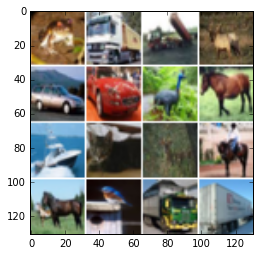

In [6]:
tiled_train_data = tilePatches(np.transpose(data_train[:16, ::] , [1, 2, 3, 0]), ncol=4)
plt.imshow(tiled_train_data/255)
print("labels_train[0, :] =",labels_train[0,:])

## Digression warning! A little data handler
We will introduce our own simplified data handler to retrieve minbatches for training. This handler creates a data object that provides a minibatch from the training data and keeps track of the instances that have been already used as well as shuffling. 

In [7]:
class Data(object):
    """
    Data class takes care of the minibatch management

    There are two optional parameters for Data objects.
    -- batch_size: if lefts as None will use the entire data set for 
       each pass.
    -- shuffle: wich defaults to true will shuffle data points to feed 
       the network at each iteration. When a epoch has been reached, 
       data is reshuffled.
    """
    batch_iter = None 
    data_size = None
    batch_idx = None
    crt_idx = None
    n_batches = None
    shuffle = None
    
    def __init__(self, data, batch_size=None, shuffle=True):
        self.data = data
        self.data_size = data.shape[0]
        self.shuffle = shuffle
        if batch_size is None:
            self.batch_size = self.data_size
            self.batch_iter = None
            self.batch_idx = None
            self.shuffle = False
        else:
            assert self.data_size >= batch_size, 'batch_size exeeds number of data samples'
            self.batch_size = batch_size
            self.batch_iter = 0
        self.n_batches = np.int64(self.data_size / self.batch_size)
        leftovers = self.data_size % self.batch_size
                
    def getBatch(self):
        if self.batch_iter is None:
            return self.data
  
        if self.batch_iter == 0:
            ## shuffle data at the begining of every epoch
            if self.shuffle is True:
                self.batch_idx = np.random.permutation(self.data_size)
            else:
                self.batch_idx = np.arange(self.data_size, dtype=np.int64)
            self.batch_idx = np.reshape(self.batch_idx, (self.n_batches, -1))
        self.crt_idx = self.batch_idx[self.batch_iter, :]
        batch = self.data[self.crt_idx, ::]
        self.batch_iter += 1
        if self.batch_iter == self.n_batches:
            self.batch_iter = 0
        return batch

    def getDataAsIn(self, ref_data_object=None):
        """
        This is an auxiliary method with the purpose of selecting
        the corresponding data-target pairs. 
        """
        if ref_data_object.crt_idx is not None:
            return self.data[ref_data_object.crt_idx, ::]
        else:
            return self.data

class CifarData(object):
    def __init__(self, data, labels, batch_size=None):
        self.data = Data(data, batch_size=batch_size)
        self.labels = Data(labels)
    
    def next_batch(self):
        return self.data.getBatch(), self.labels.getDataAsIn(self.data)

cifar_train = CifarData(data_train, labels_train, batch_size=100)

#cifar_train.next_batch()
cifar_test = CifarData(data_test, labels_test, batch_size=100)


## The CIFAR10 network
Our cifar network is a composition of convolutional, pooling and fully connected layers. RGB images are centered and feed to a convolutional layer with 32 output channels and relu activation, followed by a maxpooling operation on 3x3 portions of the map with subsampling factor of 2 (strides of 2). The second convolution also has 32 output channesl and relu nonlinearity, again followed by a maxpooling with strides of 2. The third convolutional layer increases the number of output channels to 64 using the relu nonlinearity and being followed by average pooling with subsampling factor of 2. Finally, the resulting spatial maps after the third pooling layer are flattend to a vector which inputs to a fully connected layer with sofmax activation function. Notice that, for numerical stability, the softmax is only icluded later withing the cost function along with the cross entropy loss to train the network. 

In [8]:
class Cifar10ConvNet():
    def __init__(self, params_file=None):
        self.conv1 = ConvLayer((5, 5, 3, 32), 1,'relu', stddev=0.0001, bias=0.01)
        self.pool1 = PoolLayer((3, 3), 2,'MAX', 'VALID')
        self.conv2 = ConvLayer((5, 5, 32, 32), 1,'relu', stddev=0.01, bias=0.01)
        self.pool2 = PoolLayer((3, 3), 2,'MAX', 'VALID')
        self.conv3 = ConvLayer((5, 5, 32, 64), 1,'relu', stddev=0.01, bias=0.01)
        self.pool3 = PoolLayer((3, 3), 2, 'AVG', 'VALID')
        self.fc4 = FullyConnectedLayer((9*64, 10), 'identity', stddev=0.01, bias=0.01)

        
    def forward(self, X):
        conv1 = self.conv1.forward(X)
        pool1 = self.pool1.forward(conv1)
        conv2 = self.conv2.forward(pool1)
        pool2 = self.pool2.forward(conv2)
        conv3 = self.conv3.forward(pool2)
        pool3 = self.pool3.forward(conv3)
        fc4 = self.fc4.forward(tf.reshape(pool3, [-1,9*64]))
        return fc4
    
    def saveParamsToFile(self, file_name):
        params_dict = {'conv1' : [self.conv1.params['W'].eval(), self.conv1.params['b'].eval()],\
                  'conv2' : [self.conv2.params['W'].eval(), self.conv2.params['b'].eval()],\
                  'conv3' : [self.conv3.params['W'].eval(), self.conv3.params['b'].eval()],\
                  'fc4' : [self.fc4.params['W'].eval(), self.fc4.params['b'].eval()]}
        with open(file_name, 'wb') as fo:
            cPickle.dump(params_dict, fo)
    
    def loadParamsFromFile(self, params_file_name):
        with open(params_file_name, 'rb') as fo:
            params_dict = cPickle.load(fo)
        self.conv1.params['W'].load(params_dict['conv1'][0])
        self.conv1.params['b'].load(params_dict['conv1'][1])
        self.conv2.params['W'].load(params_dict['conv2'][0])
        self.conv2.params['b'].load(params_dict['conv2'][1])
        self.conv3.params['W'].load(params_dict['conv3'][0])
        self.conv3.params['b'].load(params_dict['conv3'][1])
        self.fc4.params['W'].load(params_dict['fc4'][0])
        self.fc4.params['b'].load(params_dict['fc4'][1])

my_net = Cifar10ConvNet()

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
pred = my_net.forward(x)
# create loss to train
label = tf.placeholder(tf.float32, shape=[None, 10])
# Use combined logsig and xent to have numerically stable gradients
xent_cost = tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(labels=label, logits=pred))
train_step = tf.train.MomentumOptimizer(0.001, 0.9).minimize(xent_cost)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

## Train the network
You can skip the next cell if you want to use a pretrained model we have provided.

In [ ]:
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

n_test_iter = 100
for i in range(10000):
    batch_xs, batch_ys = cifar_train.next_batch()
    batch_xs = batch_xs - data_mean
    ## display training accuracy 
    if i%1000 == 0:
        test_accuracy = 0.0;
        for iTst in range(n_test_iter):
            batch_test_xs, batch_test_ys = cifar_test.next_batch()
            batch_test_xs = batch_test_xs - data_mean
            test_accuracy += accuracy.eval(feed_dict={
                x:batch_test_xs, label: batch_test_ys})
        test_accuracy /=n_test_iter
        train_accuracy = accuracy.eval(feed_dict={
                x:batch_xs, label: batch_ys})
        train_cost = xent_cost.eval(feed_dict={
                x:batch_xs, label: batch_ys})
        print("step %d, training cost %g, training accuracy %g, test accuracy %g"%(i, train_cost, train_accuracy, test_accuracy))
    ## 
    sess.run(train_step, feed_dict={x: batch_xs, label: batch_ys})

# save params in file just in case you want to revisit the rest of this notebook later
my_net.saveParamsToFile('./models/cifar_weights.pkl')

## Or load a pretrained network
If you feel you don't have time to train this network. We have you covered :)

In [9]:
my_net.loadParamsFromFile('./models/cifar_weights.pkl')

## Visualizing the receptive fields for conv1
For the first convolutional layer, we can get a good idea of what a particular unit is sensitive to by looking at the convolution weights of each unit. The main reason is that, for a constant energy, the image patch of the size of the receptive field for conv1 that elicit a maximal response of a unit is the filter itself scaled to the predefined energy level.  

0.307125210762 -0.340614497662


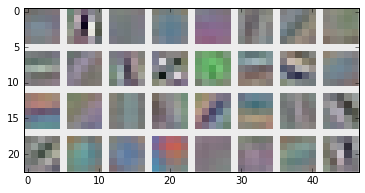

In [10]:
del tilePatches
import vis_utils
tilePatches = vis_utils.tilePatches
conv1_W = my_net.conv1.params['W'].eval()
conv1_W.shape
conv1_filters = tilePatches(np.reshape(conv1_W, [5, 5, 3, -1]), ncol=8)
print(np.max(conv1_filters), np.min(conv1_filters))
plt.imshow(1.4*conv1_filters+0.5, interpolation='none')


Before we move to visualizing conv2 units, let's perform a few calculations that will give us an idea of how things are connected and operate in a convolutional network. Namely, we will look at the size of a map and the size of the recptive field based on the connections of the unit.

## Size of a map
To compute the size of an output map, we need to consider the size of the input, height and width, the size of the particular filter operating on the input map and the subsampling factor of the operation, which is usually given by the stride. In addition, input map sizes can be altered by padding the map with zeros at their boundary, this is denoted as padding. The output sizes are obatined with the following formulas:

$$h_{\textrm{out}} = \frac{h_{\textrm{in}} + 2\cdot h_{\textrm{pad}} - f_{h}}{s_{\textrm{h}}} + 1$$
$$w_{\textrm{out}} = \frac{w_{\textrm{in}} + 2\cdot w_{\textrm{pad}} - f_{w}}{s_{\textrm{w}}}+ 1$$
where $f_h$ denotes the convolutional filter's height and $f_w$ its width. This operates in a similar way for pooling layer where the filter size is given by the pooling size.

In [11]:
def mapSize(input_sz, filter_size, stride=1, padding=0):
    return np.int32((input_sz + 2*padding - filter_size)/stride + 1)

input_map = np.asarray([32, 32])
conv1_fz = np.asarray(my_net.conv1.shape[0:2])
conv1_map = mapSize(input_map, conv1_fz, padding=(conv1_fz-1)/2)
print("Size of conv1 map is ", conv1_map)

pool1_fz = np.asarray(my_net.pool1.shape[1:3])
pool1_map = mapSize(conv1_map, pool1_fz, stride=my_net.pool1.stride[1:3])
print("Size of pool1 map is ",pool1_map)


conv2_fz = np.asarray(my_net.conv2.shape[0:2])
conv2_map = mapSize(pool1_map, conv2_fz, padding=(conv2_fz-1)/2)
print("Size of conv2 map is ",conv2_map)

pool2_fz = np.asarray(my_net.pool2.shape[1:3])
pool2_map = mapSize(conv2_map, pool2_fz, stride=my_net.pool2.stride[1:3])
print("Size of pool2 map is ",pool2_map)


conv3_fz = np.asarray(my_net.conv3.shape[0:2])
conv3_map = mapSize(pool2_map, conv3_fz, padding=(conv3_fz-1)/2)
print("Size of conv3 map is ",conv3_map)

pool3_fz = np.asarray(my_net.pool3.shape[1:3])
pool3_map = mapSize(conv3_map, pool3_fz, stride=my_net.pool3.stride[1:3])
print("Size of pool3 map is ",pool3_map)

Size of conv1 map is  [32 32]
Size of pool1 map is  [15 15]
Size of conv2 map is  [15 15]
Size of pool2 map is  [7 7]
Size of conv3 map is  [7 7]
Size of pool3 map is  [3 3]


## Computing receptive field size
Receptive field sizes operate in a backward fashion as compared to the map sizes.
$$RF_h^{(\textrm{in})} = f_{h} + {s_{\textrm{h}}} \cdot (RF_{h}^{(\textrm{out})} - 1)$$
$$RF_w^{(\textrm{in})} = f_{w} + {s_{\textrm{w}}} \cdot (RF_{w}^{(\textrm{out})} - 1)$$

In [47]:
def rfSize(filter_size, out_rf_size, stride=1):
    return filter_size + stride*(out_rf_size - 1)

conv1Toinput_rf = rfSize(conv1_fz, np.asarray([1,1]))
conv1_rf = conv1Toinput_rf
print("conv1 rf size is", conv1_rf)

pool1Toconv1_rf = rfSize(pool1_fz, np.asarray([1,1]))
conv1Toinput_rf = rfSize(conv1_fz, pool1Toconv1_rf)
pool1_rf = conv1Toinput_rf
print("pool1 rf size is",pool1_rf)

pool1_stride = my_net.pool1.stride[1:3]
conv2Topool1_rf = rfSize(conv2_fz, np.asarray([1,1]))
pool1Toconv1_rf = rfSize(pool1_fz, conv2Topool1_rf, stride=pool1_stride)
conv1Toinput_rf = rfSize(conv1_fz, pool1Toconv1_rf)
conv2_rf = conv1Toinput_rf
print("conv2 rf size is",conv2_rf)

pool2Toconv2_rf = rfSize(pool2_fz, np.asarray([1,1]))
conv2Topool1_rf = rfSize(conv2_fz, pool2Toconv2_rf)
pool1Toconv1_rf = rfSize(pool1_fz, conv2Topool1_rf, stride=pool1_stride)
conv1Toinput_rf = rfSize(conv1_fz, pool1Toconv1_rf)
pool2_rf = conv1Toinput_rf
print("pool2 rf size is",pool2_rf)

pool2_stride = my_net.pool2.stride[1:3]
conv3Topool2_rf = rfSize(conv3_fz, np.asarray([1,1]))
pool2Toconv2_rf = rfSize(pool2_fz, conv3Topool2_rf, stride=pool2_stride)
conv2Topool1_rf = rfSize(conv2_fz, pool2Toconv2_rf)
pool1Toconv1_rf = rfSize(pool1_fz, conv2Topool1_rf, stride=pool1_stride)
conv1Toinput_rf = rfSize(conv1_fz, pool1Toconv1_rf)
conv3_rf = conv1Toinput_rf
print("conv3 rf size is",conv3_rf)

pool3_rf = rfSize(pool3_fz, conv3_rf)
pool3Toconv3_rf = rfSize(pool3_fz, np.asarray([1,1]))
conv3Topool2_rf = rfSize(conv3_fz, pool3Toconv3_rf)
pool2Toconv2_rf = rfSize(pool2_fz, conv3Topool2_rf, stride=pool2_stride)
conv2Topool1_rf = rfSize(conv2_fz, pool2Toconv2_rf)
pool1Toconv1_rf = rfSize(pool1_fz, conv2Topool1_rf, stride=pool1_stride)
conv1Toinput_rf = rfSize(conv1_fz, pool1Toconv1_rf)
pool3_rf = conv1Toinput_rf
print("pool3 rf size is",pool3_rf)

pool3_stride = my_net.pool3.stride[1:3]
fc4_fz = np.asarray([3, 3])
fc4Topool3_rf = rfSize(fc4_fz, np.asarray([1,1]))
pool3Toconv3_rf = rfSize(pool3_fz, fc4Topool3_rf, stride=pool3_stride)
conv3Topool2_rf = rfSize(conv3_fz, pool3Toconv3_rf)
pool2Toconv2_rf = rfSize(pool2_fz, conv3Topool2_rf, stride=pool2_stride)
conv2Topool1_rf = rfSize(conv2_fz, pool2Toconv2_rf)
pool1Toconv1_rf = rfSize(pool1_fz, conv2Topool1_rf, stride=pool1_stride)
conv1Toinput_rf = rfSize(conv1_fz, pool1Toconv1_rf)
fc4_rf = conv1Toinput_rf
print("fc4 rf size is",fc4_rf)

conv1 rf size is [5 5]
pool1 rf size is [7 7]
conv2 rf size is [15 15]
pool2 rf size is [19 19]
conv3 rf size is [35 35]
pool3 rf size is [43 43]
fc4 rf size is [59 59]


Notice, how the recptive field sizes are even larger than the actual input image. When maps are padded, the overall result is equivalent to having a much larger input size. To verify this, let us compute the map size of pool3 from the receptive field of fc4 without padding any of the maps.

In [50]:
input_map = fc4_rf
conv1_map = mapSize(input_map, conv1_fz)
pool1_map = mapSize(conv1_map, pool1_fz, stride=my_net.pool1.stride[1:3])
conv2_map = mapSize(pool1_map, conv2_fz)
pool2_map = mapSize(conv2_map, pool2_fz, stride=my_net.pool2.stride[1:3])
conv3_map = mapSize(pool2_map, conv3_fz)
pool3_map = mapSize(conv3_map, pool3_fz, stride=my_net.pool3.stride[1:3])
print("Size of pool3 map is ",pool3_map)

Size of pool3 map is  [3 3]


## Visualize unit receptive fields by maximizing neuron's response to input stimuli of fixed energy
We can achieve this by simple gradient descent. Maximize a unit's response with respect to an input image is an optimization problem. A simple objective function would be the energy of the activation. Here, we do not solve the constrained optimization problem by explicitly enforcingt the energy constraint on the input image. Instead, we perform a simple gradient ascend update to the input image and then renormalize the input's image energy to the desired level at each step.

## Step 1: construct a subnetwork that contains the units of interest
While there exists other means to achieve the same result, we choose to declare a subnetwork that borrows the parameters of the full network to perform our unit visualization

In [12]:
## Visualize second layer units
stimuli_x = tf.placeholder(tf.float32, [None, conv2_rf[0], conv2_rf[1], 3])
stimuli = tf.Variable(tf.random_normal([1000, conv2_rf[0], conv2_rf[1], 3], stddev=55))
tf.variables_initializer([stimuli]).run()

stimuli.eval()
unit_idx = 31

class CifarV2Net():
    def __init__(self):
        self.conv1 = ConvLayer((5, 5, 3, 32), 1,'relu', 'VALID')
        self.pool1 = PoolLayer((3, 3), 2,'MAX', 'VALID')
        self.conv2 = ConvLayer((5, 5, 32, 32), 1,'relu', 'VALID')
        
        
    def forward(self, X):
        conv1 = self.conv1.forward(X)
        pool1 = self.pool1.forward(conv1)
        conv2 = self.conv2.forward(pool1)
        return conv2

my_v2net = CifarV2Net()
## use learned parameters to visualize units
my_v2net.conv1.params['W'] = my_net.conv1.params['W']
my_v2net.conv1.params['b'] = my_net.conv1.params['b']
my_v2net.conv2.params['W'] = my_net.conv2.params['W']
my_v2net.conv2.params['b'] = my_net.conv2.params['b']



## Step 2: Define the cost function

In [13]:
unit_resp = my_v2net.forward(stimuli)[:,0,0,unit_idx]
vis_cost = -tf.reduce_mean(tf.square(unit_resp)) + tf.reduce_mean(tf.square(stimuli)) 
trainer = tf.train.GradientDescentOptimizer(100)
unit_grad = trainer.compute_gradients(vis_cost, var_list=[stimuli])

## Step 3: Run multiple trials
The main reason behind this is the way we initilize our optimization problem. Since we start from Gaussian noise, there are many cases where units will not respond (in particular for relu), which results in null gradients. By runing multiple trials we should increase out chances of having at least one image that trigers a response.

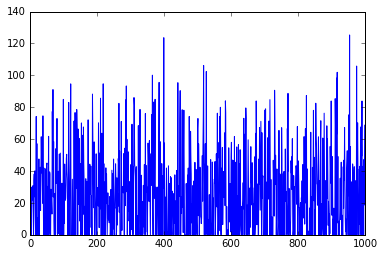

In [14]:
conv2_resp = unit_resp.eval()
plt.plot(conv2_resp.flatten())
plt.show()
for i in range(100):
    conv2_resp = unit_resp.eval()
    rf_grad = sess.run(unit_grad)
    sess.run(trainer.apply_gradients(unit_grad))
    new_stimuli = stimuli.eval()
    new_stimuli_norm = np.mean(np.reshape(np.square(new_stimuli), (new_stimuli.shape[0], -1)), axis=1)
    new_stimuli = new_stimuli /  new_stimuli_norm.reshape((-1,1,1,1))
    stimuli.assign(new_stimuli).eval()

524


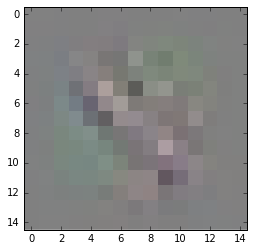

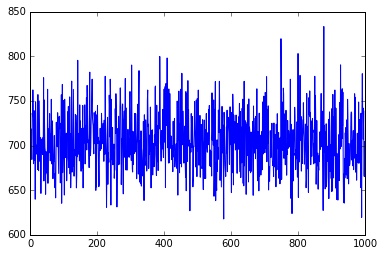

In [15]:
max_act_idx = np.argmax(conv2_resp.flatten())
print(max_act_idx)
rf = stimuli.eval() 
plt.imshow(rf[max_act_idx, ::]/1000+127, interpolation='none')
plt.show()
conv2_resp = unit_resp.eval()
plt.plot(conv2_resp.flatten())
plt.show()
#print(rf)